In [1]:
import requests
import io
url='https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5'
with requests.Session() as session:
    r = session.get(url, stream=True)
    r.raise_for_status()
    with open('SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'wb') as hd5:
        for chunk in r.iter_content(chunk_size=io.DEFAULT_BUFFER_SIZE):
            hd5.write(chunk)

In [2]:
url='https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
with requests.Session() as session:
    r = session.get(url, stream=True)
    r.raise_for_status()
    with open('SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'wb') as hd5:
        for chunk in r.iter_content(chunk_size=io.DEFAULT_BUFFER_SIZE):
            hd5.write(chunk)

In [3]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:

data_electron = h5py.File('/content/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5')
data_photon = h5py.File('/content/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5')

In [5]:
datasets = [data_electron, data_photon]
X = np.concatenate([data['/X'][:16000] for data in datasets])
y = np.concatenate([data['/y'][:16000] for data in datasets])

In [21]:
arr_X = np.zeros((32000, 32, 32, 3))
arr_X[:, :, :, :2] = X
arr_X.shape

(32000, 32, 32, 3)

In [7]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras import Sequential
from sklearn.metrics import roc_auc_score

In [22]:
X_train, X_test, y_train, y_test = train_test_split(arr_X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=35)

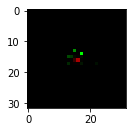

In [40]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[1000])

In [37]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape)

(23040, 32, 32, 3)
(2560, 32, 32, 3)
(6400, 32, 32, 3)
(23040,)
(6400,)
(6400, 32, 32, 3)


In [49]:
num_classes = 2
input_shape = (32, 32, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [42]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [43]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [44]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


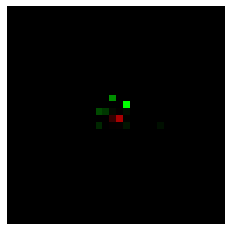

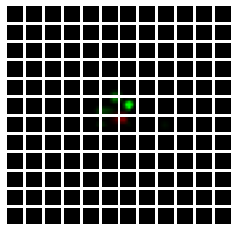

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[1000]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off") 

In [47]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [48]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [50]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=['accuracy'],
    )


    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_val, y_val)
    )
    y_pred = model.predict(X_test)
    preds = model.evaluate(X_test, y_test)
    print ("Loss = " + str(preds[0]))
    print ("Test Accuracy = " + str(preds[1]))  
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/5
90/90 [==============================] - 41s 351ms/step - loss: 7.6370 - accuracy: 0.5022 - val_loss: 7.7199 - val_accuracy: 0.5063
Epoch 2/5
90/90 [==============================] - 31s 339ms/step - loss: 7.6640 - accuracy: 0.5025 - val_loss: 7.7199 - val_accuracy: 0.5063
Epoch 3/5
90/90 [==============================] - 31s 340ms/step - loss: 7.6785 - accuracy: 0.5026 - val_loss: 7.6680 - val_accuracy: 0.5063
Epoch 4/5
90/90 [==============================] - 31s 339ms/step - loss: 7.6683 - accuracy: 0.5025 - val_loss: 7.6680 - val_accuracy: 0.5063
Epoch 5/5
200/200 [==============================] - 7s 24ms/step - loss: 7.6696 - accuracy: 0.4884
Loss = 7.669560432434082
Test Accuracy = 0.4884375035762787


In [51]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

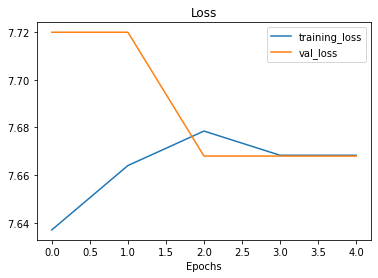

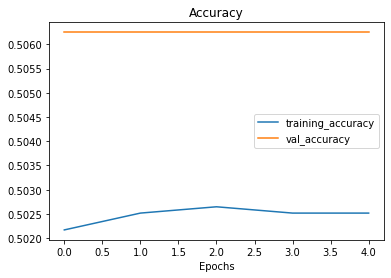

In [52]:
plot_loss_curves(history)